# Group Meeting 4

Markov Chains / State Transition Dynamics, Entropy Rate, Determinism

### Readings 

TBD

### Markov Chains

A Markov Chain is a method of representing how a system transitions between a finite number of discrete states (a related construct is a finite-state machine in computer science), typically resented as a network where the nodes are "states" and the directed edges between them are probabilities of transitioning from state $i$ to state $j$. In general, Markov Chains are defined to be memoryless - the probability of transitioning from $i$ to $j$ is solely a function of $i$ and past states have no bearing. A Markov Chain's memory can be expanded to include past steps, which is noted as a Chain of order $n$.

It is important to remember that, while a Markov Chain is a type of directed graph (and has a similar matrix sturcture), the Markov Chain describes the state-transition dynamics of a single agent (or multi-agent system). Network scientists have a tendency to automatically read each node in a network as an agent embedded in a web of interactions, and this is not the case of trivial Markov Chains.

/home/thosvarley/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2


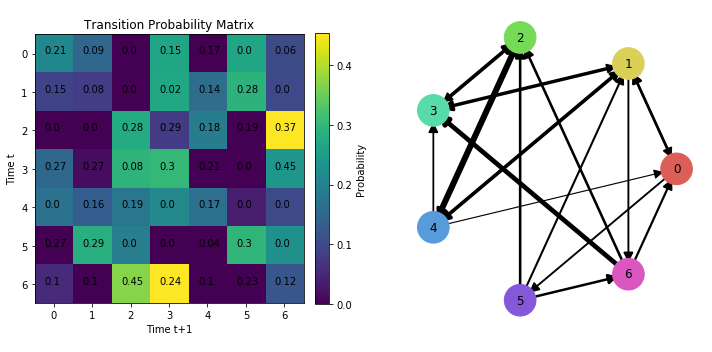

In [2]:
import numpy as np 
import networkx as nx 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from scipy.stats import entropy

#Generating a 7-state system with random probabilities
transmat = np.random.randint(0, 100, size=(7,7)).astype("float32")

#Picking a few transitions to make impossible 
dropout = np.random.randint(0,transmat.shape[0], (2,15))
for i in range(dropout.shape[1]):
    transmat[dropout[0][i]][dropout[1][i]] = 0

#Normalizing every row to sum to 1
for i in range(transmat.shape[0]):
    total = np.sum(transmat[i])
    if total != 0:
        transmat[i] = transmat[i] / total

#Making the Markov Chain itself in Networkx 
G = nx.from_numpy_array(transmat, create_using=nx.DiGraph())

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(transmat)
plt.colorbar(label="Probability", fraction=0.046, pad=0.04)
plt.title("Transition Probability Matrix")
plt.ylabel("Time t")
plt.xlabel("Time t+1")

for i in range(transmat.shape[0]):
    for j in range(transmat.shape[1]):
        plt.text(i-0.25, j, str(round(transmat[i][j], 2)))

plt.subplot(1,2,2)
nx.draw_circular(G, 
                 with_labels=True, 
                 node_color=sns.palettes.hls_palette(7),
                 node_size=10**3,
                 width = np.log2(transmat.flatten()),
                 arrowsize=20
                )
plt.tight_layout()

The transition probability matrix (TPM) $M$ is best understood in terms of conditional probabilities:

\begin{equation}
M_{ij} = P_{i\rightarrow j} = P(j | i)
\end{equation}

This provides a simple way of thinking about the notions of determinism and causality in systems. If a transition $P_{i\rightarrow j} = 1$, then we say that the transition from $i$ to $j$ is *deterministic.* Causality is a bit more philosophically invovled, but briefly, we can say that $i$ *causes* $j$ if two conditions are met. First: $P_{i\rightarrow j} \approx 1$ and second: if an intervention on $M$ of putting it into state $i$ reliably leads to $j$ (this is what Judea Pearl formalized using the $do$ operator). 

If we run a Markov Chain indefinitely, there are several possible long-term behaviors:

1) The system can become trapped in a fixed point, if there is some state who's only out-going edge is a self-loop back with a probability of 1. This is one of two possible long-term solutions if all transitions are deterministic. 

2) The system can become trapped in a limit cycle, passing through the same several points indefinitely. This is the other possible long-term solutions if all transitions are deterministic. 

3) The system can converge to a stationary distribution, which gives the probability of finding the system in each state if it is run for a long time. This can be modeled as running a random walker on the weighted network and observing how many times it visits each state. 

#### Stationary Distributions

To understand a stationary distribution, it helps to consider simpler cases. Imagine intitializing a TPM and saying that we are goign to set the system in any state, with equal probability. This works out to be a maximum entropy distribution. When we update the system, however, the distribution of possible states is likely no longer flat.

Consider a very simple case of 3 nodes:

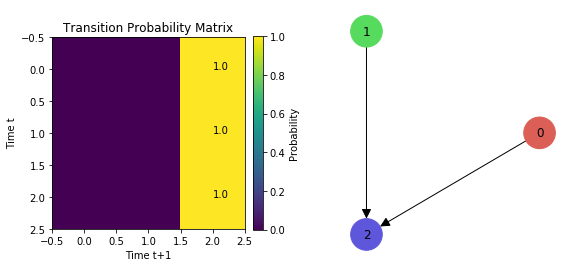

In [83]:
small_tpm = np.zeros((3,3))
small_tpm[0][2] = 1
small_tpm[1][2] = 1
small_tpm[2][2] = 1

small_G = nx.from_numpy_array(small_tpm, create_using=nx.DiGraph())

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(small_tpm)
plt.colorbar(label="Probability", fraction=0.046, pad=0.04)
plt.title("Transition Probability Matrix")
plt.ylabel("Time t")
plt.xlabel("Time t+1")

for i in range(small_tpm.shape[0]):
    plt.text(2, i, "1.0")

plt.subplot(1,2,2)
nx.draw_circular(small_G, 
                 with_labels=True, 
                 node_color=sns.palettes.hls_palette(3),
                 node_size=10**3,
                 arrowsize=20
                )
plt.tight_layout()

If, at time $t$ there is an equal probability of setting the system in any one of the three possible states (i.e. $[\frac{1}{3},\frac{1}{3},\frac{1}{3}]$) what is the probability distribution after updating one step? 

It's fairly obvious that any walker on $2$ will stay there, and any walker on $1$ or $0$ will transition to $2$, so the resulting distribution will be $[0, 0, 1]$, and no matter how much longer we run the system, it will remain the same. 

Given a TPM $M$ and a distribution at time $t$ ($\textbf{v}_t$):

\begin{equation}
\textbf{v}_{t+1} = \textbf{v}_t^T M
\end{equation}

The stationary distribution $\pi$ is then defined as:

\begin{equation}
\pi = \pi M
\end{equation}

i.e. the distribution that, when it is run through our system remains the same. Astute readers will recognize that $\pi$ turns out to be a *left eigenvector* of $M$. When doing a left eigenvalue decomposition, it will generally be the eigenvector who's associated eigenvalue is equal to $1$ and has no imaginary part. In the case of our 3-state Markov Chain, the stationary distribution is obvious by inspection. For our larger 7-state system introduced above, we can calculate $\pi$ like so:

In [3]:
from scipy.linalg import eig

w, vl, vr = eig(transmat, left=True) #Scipy.linalg has a great eigenvalue/vector estimator.
print("Eigenvalues:", w)
print(" ")
#It is clear that the first eigenvalue is our target - it has real part equal to 1 and no imaginary part. 
#To associated left eigenvector is:

print("Stationary Eigenvector:", np.real(vl[:,0]))


Eigenvalues: [ 0.99999964+0.j          0.44977123+0.j          0.2211568 +0.11490962j
  0.2211568 -0.11490962j -0.03307237+0.j         -0.2002618 +0.02737231j
 -0.2002618 -0.02737231j]
 
Stationary Eigenvector: [0.1879212  0.09942773 0.5690813  0.56246734 0.14872503 0.12041457
 0.527217  ]


In [4]:
#This usually has to be normalized to define a probability distribution

pi = np.real(vl[:,0])/np.sum(np.real(vl[:,0]))
print("Stationary Distribution:", pi)

Stationary Distribution: [0.08483053 0.04488321 0.25689209 0.25390643 0.06713678 0.054357
 0.23799388]


We can check that our $\pi$ is the true stationary distribution:

In [9]:
print("Pi at time t", pi)
print(" ")
print("Pi at time t+1", np.matmul(pi.T, transmat))
print(" ")
print("Entropy of Pi", entropy(pi, base=2), "bit")

Pi at time t [0.08483053 0.04488321 0.25689209 0.25390643 0.06713678 0.054357
 0.23799388]
 
Pi at time t+1 [0.08483052 0.04488321 0.2568921  0.25390643 0.06713674 0.05435705
 0.23799384]
 
Entropy of Pi 2.491622731946061 bit


It is pretty clear that they are the same, although be careful of using Python's $==$ operator hear: often floating point arithmatic can result in small differences on the order of $10^{-10}$, which will return $False$ when compared via $==$.

Knowing the stationary distribution gives us a very simple metric for characterizing the long-term behavior of the system: the stationary entropy $H_\pi(M)$ gives a crude measure of how uncertain the state of the system at a time $t+n, n>>1$ in the far future. 

##### Determinism

We can summarize how deterministic the entire system is by calculating the entropy of the out-going edges of each node. The average determinism is given as:

\begin{equation}
Det(M) = \log(N) - \langle(H(M_i)\rangle \forall i \in |M|
\end{equation}

where $H(M_i)$ is the entropy of the $i^{th}$ row of $M$ and $\langle\rangle$ is the average function. When the entropy is high, determinism is low, and vice-versa, matching our intuititon that the more confident we can be about the future, the more deterministic it is. 

##### Information Innovation Rate

The measure $H_\pi(M)$ gives a summary measure of the long-term predictability of $M$, however it doesn't provide any temporal resolution - it is just a measure of how good you would be at guessing the state of the system at some point in the future. 

To get a time-resolved measure of system uncertainty, we can calculate the *information innovation rate* $H'(M)$ of the system:

\begin{equation}
H'(M) = H(M_{t+1} | M_t, M_{t-1}, M_{t-2} ... M_2, M_1)
\end{equation}

We can think of this as the uncertainty present in the next transition after all possible information from the past has been accounted for. In the case of a memoryless Markov Process:

\begin{equation}
H'(M) = H(M_{t+1}|M_t)
\end{equation}

As the only the immediate present effects the updating probabilities, however in real complex systems, there is often active information storage which means that information about the past can be used to help predict the future.

Consequently, in real data, the rate of information innovation can be used to estimate the natural timescale of the system. We can find some $k$, such that:

\begin{equation}
H(M_{t+1} | M_t, M_{t-1}, M_{t-2} ... M_{t-k}) = H(M_{t+1} | M_t, M_{t-1}, M_{t-2} ... M_{t-k}, M_{t-k-1})
\end{equation}

Here, $k$ is the lag after which knowing more about the past doesn't necessarilly give you any more insights into what the future is likely to be. This is generally denoted as $H'^k(M)$ to differentiate the finit stopping time of $t-k$ from the general case of $H'(M)$, where the entire past is considered.

##### Entropy Rate

A very closely related measure is the entropy rate, which is a measure of the time-density of information production by the system per unit time. 

\begin{equation}
H_\mu(M) = \lim_{n \rightarrow \infty}\frac{H(M_t, M_{t-1}, M_{t-2} ... M_{n+1}, M_n}{n})
\end{equation}

This can be thought of as something like "how much information is generated per unit time" over all time. If the joint state is highly constrained, then the joint entropy is low, and as $n \rightarrow \infty$, $H_\mu(M) \rightarrow 0$. Alternately, if each new state is unique and unexpected, then the entropy rate remains high.

For a stationary process with distribution $\pi$, 

\begin{equation}
H_\mu(M) = -\sum\pi_i M_{ij}\log(M_{ij})
\end{equation}


### Comparing Two Markov Chains

Suppose you have two Markov Chains and you want to compare them directly. There are a few ways to do that, depending on the chains themselves. 

1) If both chains have the same states, the simplest method is flattening them and doing a Spearman correlation of the two flattened vectors. This is the easiest, but also the crudest. 

2) If both chains have the same states, you can also compare their two stationary distributions $\pi_i, \pi_j$. Possible comparators include: KL Divergence, KS Distance, Earth-Mover's Distance. 

3) If both chains have the same states, you can compare the out-going distributions for each state (i.e. pairwise comparisson of rows in the TPMs). This gives you the most "high resolution" picture, since it compares each state to it's twin in the other Chain, and then aggregates those local similarities (usually by averaging). 

4) If the chains **don't** have the same states, you need to think really hard about what you hope to get by comparing them. If what you're interested in is the overall state-transition topology, and not the individual states or stationary distributions, you could use the Network Portrait Divergence by Bagrow and Bolt (2019) 

https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0156-x

The issue of graph comparisson is really complicated and more than we can get into here. There is not, at present, a unanamously agreed upon measure. 


### Mutual Information Between Past and Future

When dealing with a complex system that evolves through time, a natural question is "how structured is it?" or alternatley 